In [16]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

dataroot = '../WaterLevelPredction_SelectingModel//Data/'

In [17]:
df = pd.read_pickle(dataroot+'finaldata.pkl')

In [18]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=4, test_size=365)
df = df.sort_index()

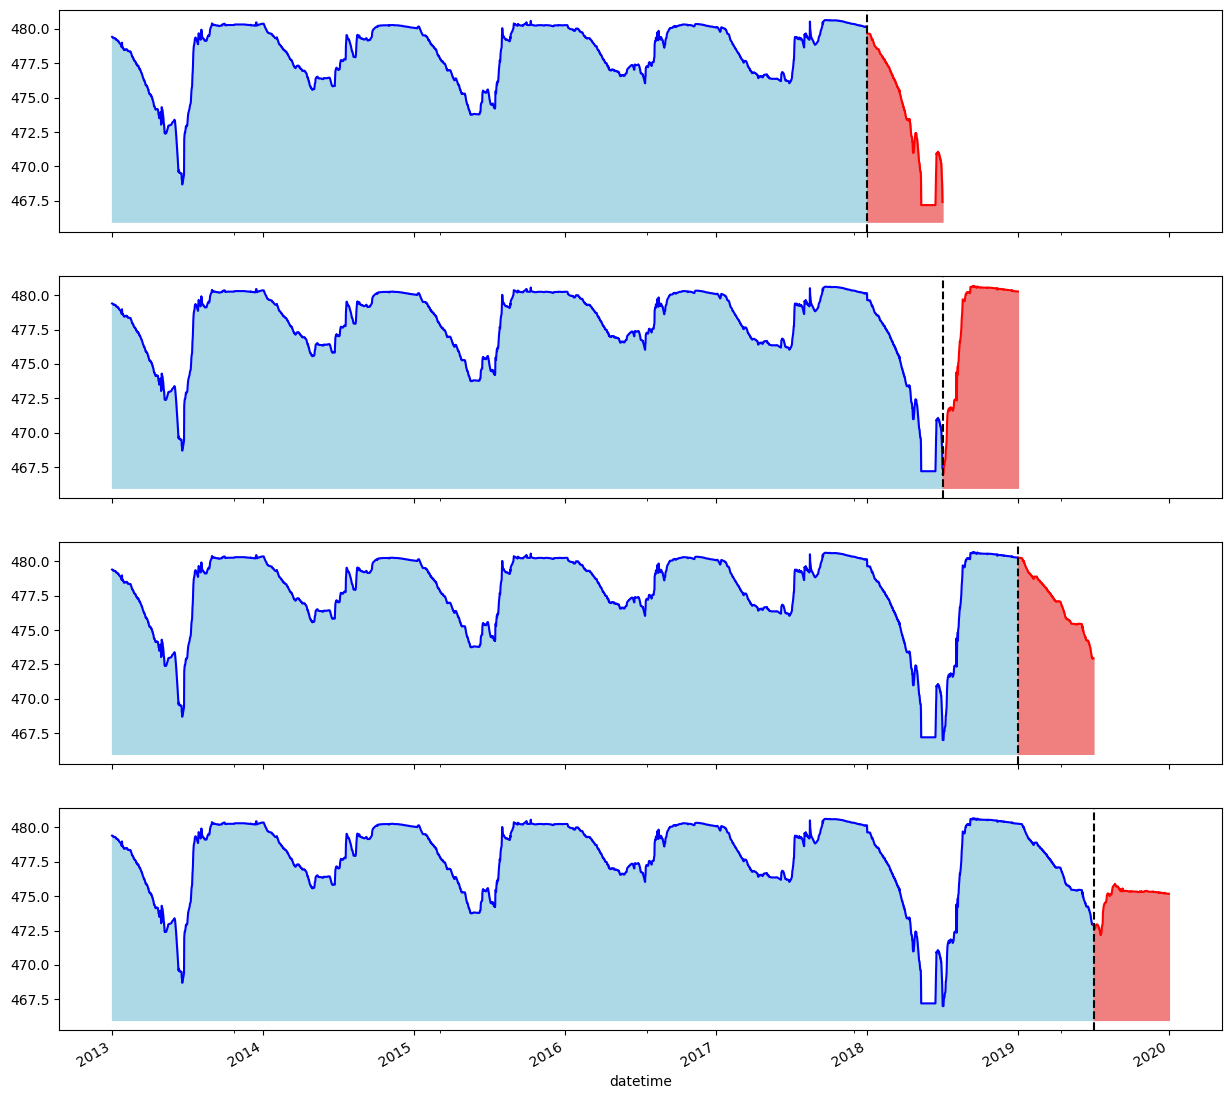

In [19]:
fig, axs = plt.subplots(4,1, figsize = (15,15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['water_level'].plot(ax=axs[fold],
                              label='Tập huấn luyện',
                              color='blue')
    test['water_level'].plot(ax=axs[fold],
                             label='Tập kiểm thử',
                             color='red')
    axs[fold].fill_between(train.index,466, train['water_level'], color='lightblue')
    axs[fold].fill_between(test.index,466, test['water_level'], color='lightcoral')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold+=1
plt.show()

In [20]:
#Create Lag Feature
def add_lag(df):
    target_map = df['water_level'].to_dict() #mapping water level
    df['lag'] = (df.index - pd.Timedelta('12 hours')).map(target_map)
    return df

df = add_lag(df)

In [21]:
from xgboost import XGBRegressor

fold = 0
preds = []
rmses = []
maes = []
r2s = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    features = ['hour','precipitation','sluice_status','lag']
    target = 'water_level'
    
    X_train = train[features]
    y_train = train[target]
    
    X_test = test[features]
    y_test = test[target]
    
    xgb_reg = XGBRegressor(n_estimators=1000,
                           learning_rate=0.01,
                           early_stopping_rounds=20,
                          )
    xgb_reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train),(X_test, y_test)],
        verbose=True)
    
    y_pred = xgb_reg.predict(X_test)
    preds.append(y_pred)
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    rmses.append(rmse)
    mae = mean_absolute_error(y_test,y_pred)
    maes.append(mae)
    r2 = r2_score(y_test,y_pred)
    r2s.append(r2)

[0]	validation_0-rmse:2.11765	validation_1-rmse:6.30630
[1]	validation_0-rmse:2.09686	validation_1-rmse:6.25295
[2]	validation_0-rmse:2.07627	validation_1-rmse:6.20011
[3]	validation_0-rmse:2.05589	validation_1-rmse:6.14782


[4]	validation_0-rmse:2.03571	validation_1-rmse:6.09606
[5]	validation_0-rmse:2.01573	validation_1-rmse:6.04480
[6]	validation_0-rmse:1.99596	validation_1-rmse:5.99406
[7]	validation_0-rmse:1.97637	validation_1-rmse:5.94383
[8]	validation_0-rmse:1.95698	validation_1-rmse:5.89411
[9]	validation_0-rmse:1.93779	validation_1-rmse:5.84487
[10]	validation_0-rmse:1.91879	validation_1-rmse:5.79615
[11]	validation_0-rmse:1.89998	validation_1-rmse:5.74790
[12]	validation_0-rmse:1.88135	validation_1-rmse:5.70014
[13]	validation_0-rmse:1.86291	validation_1-rmse:5.65284
[14]	validation_0-rmse:1.84465	validation_1-rmse:5.60603
[15]	validation_0-rmse:1.82658	validation_1-rmse:5.55970
[16]	validation_0-rmse:1.80868	validation_1-rmse:5.51404
[17]	validation_0-rmse:1.79097	validation_1-rmse:5.46861
[18]	validation_0-rmse:1.77343	validation_1-rmse:5.42363
[19]	validation_0-rmse:1.75607	validation_1-rmse:5.37911
[20]	validation_0-rmse:1.73887	validation_1-rmse:5.33525
[21]	validation_0-rmse:1.72186	valida

In [22]:
print(f'mean squared error across fold:{np.mean(rmse)}')
print(f'score for each fold:{rmses}')
print(f'mean absolute error across fold:{np.mean(mae)}')
print(f'score for each fold:{maes}')
print(f'r2 score across fold:{np.mean(r2)}')
print(f'score for each fold:{r2s}')

mean squared error across fold:0.08398713338178815
score for each fold:[1.1199712043280288, 0.3427004324064184, 0.07198587318009028, 0.08398713338178815]
mean absolute error across fold:0.05049714723352063
score for each fold:[0.6137957379066794, 0.2175949372592044, 0.038052774507704654, 0.05049714723352063]
r2 score across fold:0.9911292510677172
score for each fold:[0.9304439140741513, 0.9923430440940686, 0.9986295256226899, 0.9911292510677172]


<Figure size 1000x500 with 0 Axes>

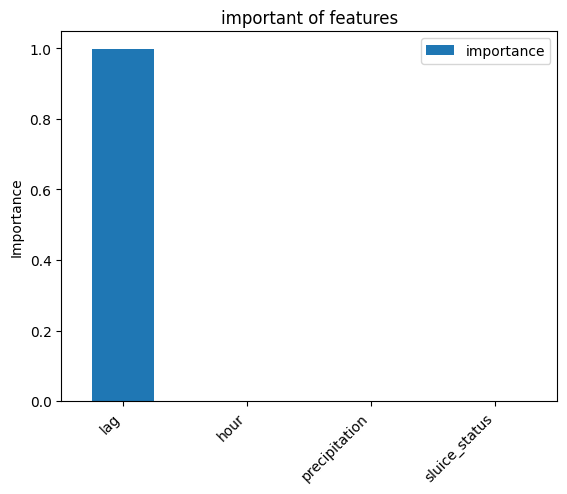

In [23]:
fi = pd.DataFrame(data=xgb_reg.feature_importances_,
              index=xgb_reg.feature_names_in_,
              columns=['importance'])
plt.figure(figsize=(10, 5))
fi = fi.sort_values(by='importance', ascending=False)
fi.plot(kind='bar', legend=True)
plt.title('important of features')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')
plt.show()

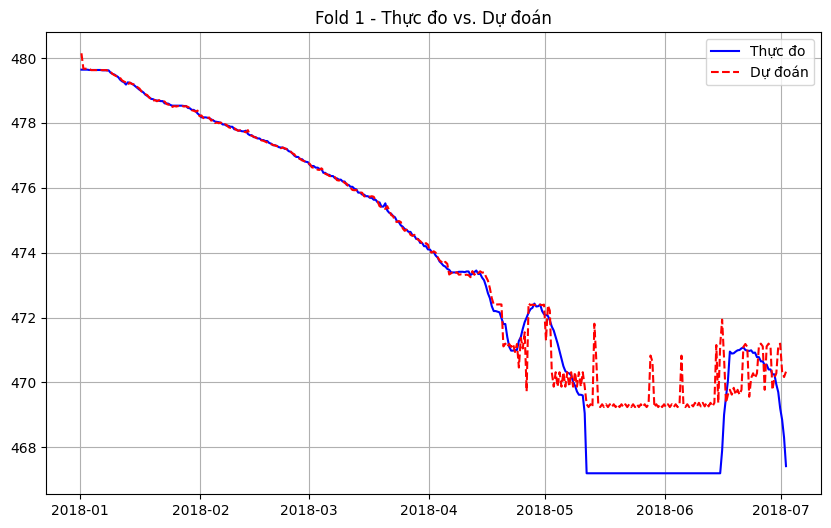

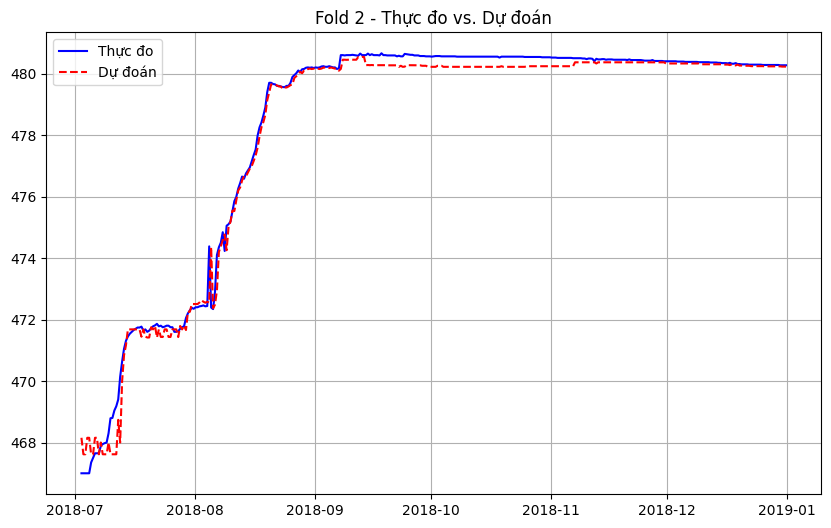

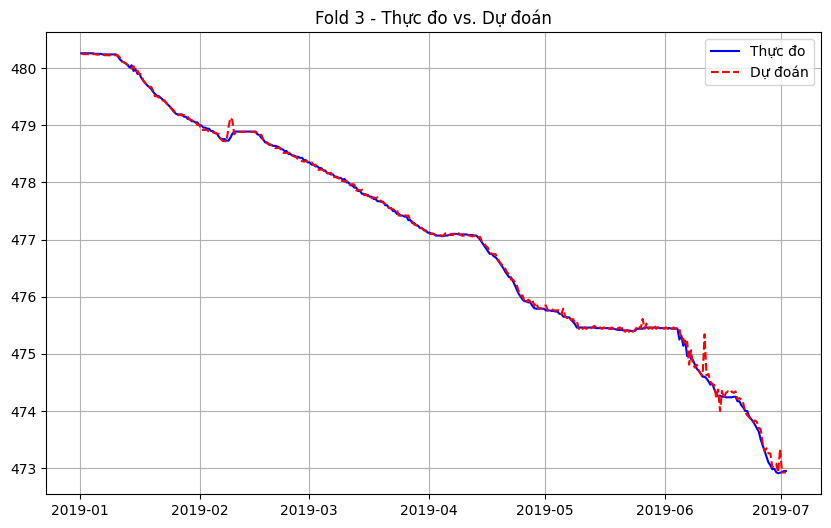

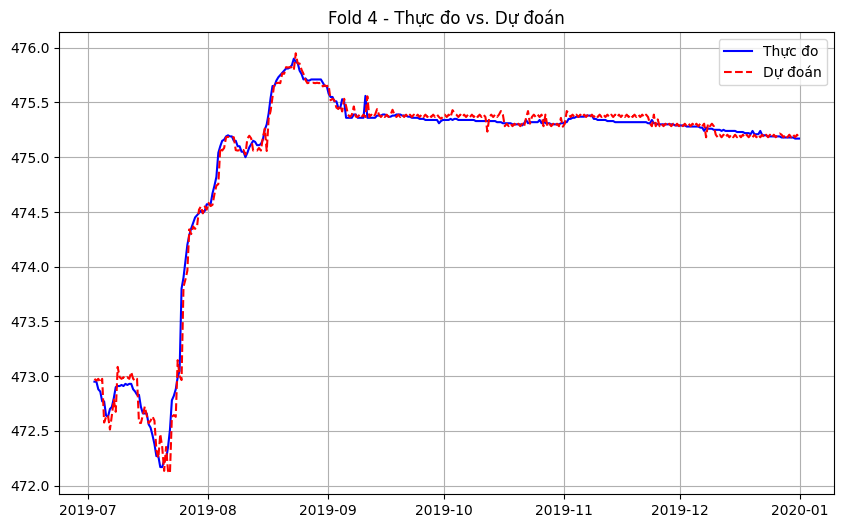

In [24]:
fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    plt.figure(figsize=(10, 6))
    plt.plot(test.index, test['water_level'], label='Thực đo', color='blue')
    plt.plot(test.index, preds[fold], label='Dự đoán', color='red', linestyle='dashed')
    fold += 1

    plt.title('Fold {} - Thực đo vs. Dự đoán'.format(fold))

    plt.legend()
    plt.grid()
    plt.show()